In [115]:
import Pkg
Pkg.add("Convex")
Pkg.add("SCS")

   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


   Resolving package versions...


  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


In [220]:
using Convex
include("./dbf_freeform.jl")
include("../sensor.jl")
order = 1;      # Order of Differential Beamformer
freq = 50;    # Frequency of Interest (in Hz)
c0 = 1500;       # Speed of Medium (m/s)
az = 30;        # Angle (in degrees)

ψ_mat = create_ψ_matrix(sensors_underwater, order, freq, c0);
γ = steering_matrix(az, order);
v = ones(Rational, 2*order+1); # Weights associated with DBF
v .//= size(v,1);
h = ComplexVariable(length(sensors_underwater), 1)
# create_ψ_matrix()

sensors Loaded: (8,)
sensors1 Loaded: (25,)
sensors2 Loaded: (20,)
sensors_underwater loaded: (40,)


Variable
size: (40, 1)
sign: complex
vexity: affine
id: 124…482

In [221]:
polar_sensor = sensors_in_polar(sensors_underwater)
d_vec(f, θ, polar::Vector, c0=1500) = exp(1im * 2 * π * f * polar[1] / c0 * cos(θ - polar[2]))
d = d_vec.(freq, az, polar_sensor, c0)

40-element Vector{ComplexF64}:
 0.9998695403206286 + 0.016152471607001166im
   0.99947819532197 + 0.032300728721468525im
 0.9988260671135106 + 0.048440557950510936im
 0.9979133258481242 + 0.06456774810023577im
 0.9967402096776765 + 0.08067809127453081im
 0.9884281766156378 + 0.15168961623092578im
 0.9989721626083314 - 0.04532789796177837im
  0.988084775571357 - 0.1539106113434067im
 0.9956409008515075 - 0.09326948349593604im
  0.982597763408815 - 0.18574615835595237im
                    ⋮
 0.9546493549317819 + 0.2977324455418534im
 0.9946602294730141 + 0.10320381729708865im
 0.9786936955363762 + 0.20532571762288088im
 0.9522520294773503 + 0.30531307269140573im
 0.9156993319258852 + 0.40186407342593783im
 0.8692846611831991 + 0.4943118224679749im
 0.9366588470207429 + 0.35024306459624943im
 0.9471962382450095 + 0.3206544655146768im
 0.9715508382832093 + 0.23683109726383764im

In [222]:
function find_h_opt(ψ_mat, γ, d, v, wng_pow = 10 ^ (-0/10))
    h = ComplexVariable(size(ψ_mat, 2));
    objective = norm(ψ_mat * h - γ' * v, 2);
    constraints = [1 ./ wng_pow >= norm(h,2), d' * h == 1];
    problem = minimize(objective, constraints);

    solve!(problem, SCS.Optimizer; silent_solver = true);
    h_opt = evaluate(h);
    return h_opt
end

find_h_opt (generic function with 4 methods)

In [196]:
using SCS
wng_pow = 10 ^ (4/10);
objective = norm(ψ_mat * h - γ' * v, 2)
constraints = [1 ./ wng_pow >= norm(h,2), d' * h == 1]
problem = minimize(objective, constraints)

solve!(problem, SCS.Optimizer)

------------------------------------------------------------------
	       SCS v3.2.1 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
------------------------------------------------------------------
problem:  variables n: 83, constraints m: 92
cones: 	  z: primal zero / dual free vars: 3
	  l: linear vars: 1
	  q: soc vars: 88, qsize: 2
settings: eps_abs: 1.0e-04, eps_rel: 1.0e-04, eps_infeas: 1.0e-07
	  alpha: 1.50, scale: 1.00e-01, adaptive_scale: 1
	  max_iters: 100000, normalize: 1, rho_x: 1.00e-06
	  acceleration_lookback: 10, acceleration_interval: 10
lin-sys:  sparse-direct-amd-qdldl
	  nnz(A): 625, nnz(P): 0
------------------------------------------------------------------
 iter | pri res | dua res |   gap   |   obj   |  scale  | time (s)
------------------------------------------------------------------
     0| 5.03e+01  1.00e+00  5.04e+01 -2.51e+01  1.00e-01  3.21e-04 
   125| 4.56e-05  1.26e-05  1.46e-05  5.27e-01  1.23e+00  8.06e-04 
---------

In [197]:
h_opt = evaluate(h);
con1 = (1 ./ norm(h_opt,2) >= wng_pow);
con2 = (d' * h_opt == 1.0);
err_con2 = abs(d' * h_opt - 1);
println("Constraint 1: $con1")
println("Constraint 2: $con2 w/ error: $err_con2")

Constraint 1: false
Constraint 2: false w/ error: 3.2860288791394956e-8


In [198]:
function check_constraints(h_opt, wng_pow, d)
    con1 = (1 ./ norm(h_opt,2) >= wng_pow);
    con2 = (d' * h_opt == 1.0);
    err_con2 = abs(d' * h_opt - 1);
    println("Constraint 1: $con1")
    println("Constraint 2: $con2 w/ error: $err_con2")
end

check_constraints (generic function with 1 method)

In [199]:
h_opt

40-element Vector{ComplexF64}:
  0.019603225465987258 + 0.022265377427769493im
    0.0255823490460962 + 0.04444958948918582im
   0.03549870397255172 + 0.06647040586234029im
   0.04926680513440945 + 0.08824804379419907im
   0.06676802493964404 + 0.10970485123735317im
  0.033270135539216185 + 0.08424635326144661im
   0.04157455652258526 + 0.06176786077074438im
  0.030135442987031223 + 0.03584753161526091im
  0.016295166269318408 - 0.0034493117590531004im
  0.012345346360047891 - 0.006834421777953946im
                       ⋮
  0.003858955114715121 + 0.010830643968779434im
  0.015508636548410643 + 0.01717054471704733im
  0.009245127062642414 + 0.03400345206418635im
 -0.001102993611885212 + 0.05016444848408232im
 -0.015365940914398545 + 0.06530395757949556im
 -0.033413362115045565 + 0.07914022912802182im
  -0.00745138817201765 + 0.037977829912391216im
 0.0008378650331362146 + 0.07239629385510886im
  0.017106697488001383 + 0.07878899543727604im

In [200]:
some_pow = db2pow(4);
another_pow = 10^(4/10);
println("$some_pow , $another_pow")

2.51188643150958 , 2.51188643150958


In [223]:
az_list = -180:180
h_filters = Dict();
wng_pow = db2pow(4);
for az in az_list
    γ = steering_matrix(az, order);
    d = d_vec.(freq, deg2rad(az), polar_sensor, c0);
    h_filters[az] = find_h_opt(ψ_mat, γ, d, v, wng_pow);
    # println("For Azimuth Angle: $(az)°")
    # check_constraints(h_filters[az], 1, d)
end

In [213]:

#=
Step 0: Open recording or generate signal
=#

# To Generate Signal:
include("../signal_generator/tone.jl")

freq = 50;          # Frequency of Tone (in Hz)
amp = 1;            # Amplitude of Tone
duration = 10;       # Duration of Tone (in seconds)
sample_rate = 32000.0;
tone_sig, n = tone(duration, amp, freq, sample_rate);

In [214]:
include("../signal_generator/generate_sig.jl")
az_gt = -90;
NFFT = 2^11;
noverlap = Int(NFFT * (3 // 4));
new_sig, sample_rate = simulate_sensor_signal(tone_sig, sample_rate, sensors_underwater,
                         NFFT, noverlap, hanning, az_gt, c0);

Start Simulating Signal
Signal has size: (320000, 1)


  2.590283 seconds (404.95 k allocations: 1.463 GiB, 39.34% gc time, 3.94% compilation time)
Now Generated Signal has size: (320000, 40)


In [215]:
using Random
using DSP: db2amp, pow2db
rng = Random.seed!(1234);
noise_pow = 4; # in dB
noise = rand(rng, size(new_sig,1), size(new_sig,2));
noisy_sig = new_sig + db2amp(noise_pow) .* noise;

In [216]:
function filter_freq_per_ch(new_sig)
    new_S = []
    for sig in eachcol(new_sig)
        S_interest = choose_freq(sig, freq, sample_rate);
        push!(new_S, S_interest);
    end
    # test_sig = Matrix{}(undef, size(new_sig, 2)) 
    new_S = mapreduce(permutedims, vcat, new_S);
    return new_S
end

new_S = filter_freq_per_ch(new_sig);
using Statistics
n_snapshots = 64;
Rx = cov(new_S[:,1:n_snapshots], dims=2);

In [217]:
P = [];
for az in az_list
    h_opt = h_filters[az];
    P_val = h_opt' * Rx * h_opt;
    push!(P, abs(P_val));
end

In [218]:
include("./cbf.jl")
P_db, az_max = predict_az(P, az_list)

([-8.144259176934163, -7.915409693591712, -7.692365470792062, -7.4749048536630625, -7.26282069134362, -7.055919110054106, -6.854018413323473, -6.65694809376555, -6.464547943314955, -6.276667250644472  …  -10.510992271168078, -10.216690871643003, -9.93113700770467, -9.653890427793208, -9.384546422173862, -9.122732127392219, -8.868103295881554, -8.620341462585188, -8.379151451780771, -8.144259176933879], -90)

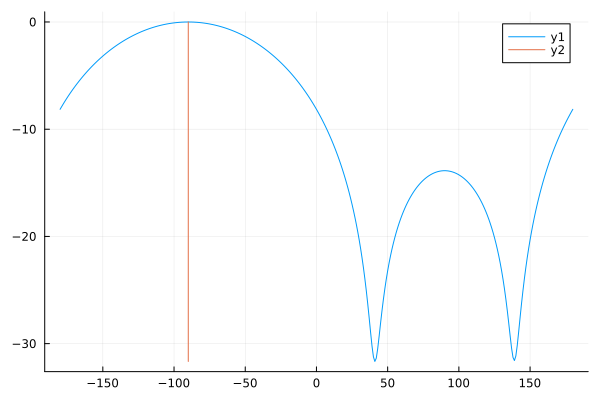

In [219]:
using Plots
ymin = minimum(P_db);
plot1 = plot(az_list, P_db)
plot!([az_max; az_max], [ymin; 0])
display(plot1)

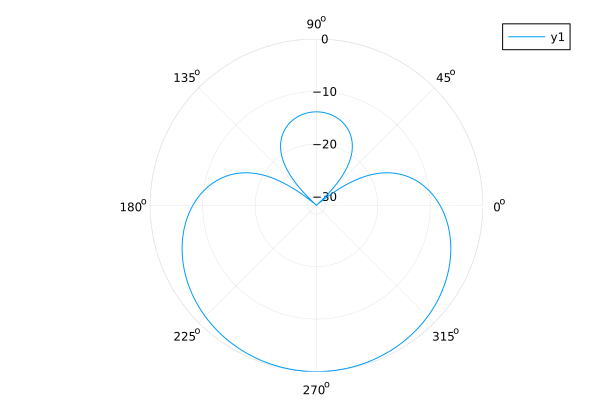

In [209]:
plot(deg2rad.(az_list), P_db, proj=:polar)
ylims!((ymin, 0))